In [1]:
import numpy as np
from sklearn.model_selection import KFold
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

# Datenvorverarbeitung

In [2]:
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_D4_I7000_F9000/TPath_500_finish_data_D4.pkl')
data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,500,7000,9000,669.05
1,0.0000,-0.00192,500,7000,9000,724.42
2,0.0000,-0.00184,500,7000,9000,779.83
3,0.0000,-0.00176,500,7000,9000,835.21
4,0.0000,-0.00168,500,7000,9000,890.44
...,...,...,...,...,...,...
1066,0.0024,0.00168,500,7000,9000,775.40
1067,0.0024,0.00176,500,7000,9000,715.43
1068,0.0024,0.00184,500,7000,9000,645.85
1069,0.0024,0.00192,500,7000,9000,585.87


In [3]:
# Droppen nicht benötigter Spalten
df = data.drop(data.columns[2:5], axis = 1)
df

,X-Koordinate,Y-Koordinate,Temperatur
0,0.0000,-0.00200,669.05
1,0.0000,-0.00192,724.42
2,0.0000,-0.00184,779.83
3,0.0000,-0.00176,835.21
4,0.0000,-0.00168,890.44
...,...,...,...
1066,0.0024,0.00168,775.40
1067,0.0024,0.00176,715.43
1068,0.0024,0.00184,645.85
1069,0.0024,0.00192,585.87


In [4]:
df.describe()

,X-Koordinate,Y-Koordinate,Temperatur
count,1071.000000,1.071000e+03,1071.000000
mean,0.001200,8.422560e-20,1138.089346
std,0.000727,1.178118e-03,272.294437
min,0.000000,-2.000000e-03,574.640000
25%,0.000600,-1.040000e-03,925.435000
50%,0.001200,4.529900e-18,1200.300000
75%,0.001800,1.040000e-03,1371.000000
max,0.002400,2.000000e-03,1519.900000


In [5]:
# Randomisieren der Anordnung
df1 = df.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen
print(df1)
df_reset = df1.reset_index(drop=True)
df_reset

      X-Koordinate  Y-Koordinate  Temperatur
184        0.00036       0.00048     1441.10
572        0.00132      -0.00112     1225.70
309        0.00072      -0.00176      832.88
930        0.00216      -0.00104     1158.00
711        0.00156       0.00184      642.96
...            ...           ...         ...
330        0.00072      -0.00008     1500.20
466        0.00108      -0.00144     1045.00
121        0.00024      -0.00048     1484.90
1044       0.00240      -0.00008     1259.10
860        0.00192       0.00152      861.75

[1071 rows x 3 columns]


,X-Koordinate,Y-Koordinate,Temperatur
0,0.00036,0.00048,1441.10
1,0.00132,-0.00112,1225.70
2,0.00072,-0.00176,832.88
3,0.00216,-0.00104,1158.00
4,0.00156,0.00184,642.96
...,...,...,...
1066,0.00072,-0.00008,1500.20
1067,0.00108,-0.00144,1045.00
1068,0.00024,-0.00048,1484.90
1069,0.00240,-0.00008,1259.10


In [6]:
#Festlegen der Gesamtdaten
label = df_reset["Temperatur"]
df1 = df_reset.drop("Temperatur", axis=1)
X = df1
y = label

In [7]:
X

,X-Koordinate,Y-Koordinate
0,0.00036,0.00048
1,0.00132,-0.00112
2,0.00072,-0.00176
3,0.00216,-0.00104
4,0.00156,0.00184
...,...,...
1066,0.00072,-0.00008
1067,0.00108,-0.00144
1068,0.00024,-0.00048
1069,0.00240,-0.00008


In [8]:
y

0       1441.10
1       1225.70
2        832.88
3       1158.00
4        642.96
         ...   
1066    1500.20
1067    1045.00
1068    1484.90
1069    1259.10
1070     861.75
Name: Temperatur, Length: 1071, dtype: float64

In [9]:
# Festlegen der Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [10]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)  # Nutze unterschiedliche Skalierungsparameter

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel
scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))


In [11]:
X_train_scaled

array([[0.35, 0.88],
       [0.75, 0.88],
       [0.85, 0.02],
       ...,
       [0.2 , 0.86],
       [1.  , 0.52],
       [0.8 , 0.04]])

In [12]:
y_train_scaled.max()

1.0

In [15]:
# Netzwerkarchitektur
model = Sequential([

    Dense(264, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

    Dense(232, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(280, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(264, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(72, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(88, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 25
epochs = 1000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
28/28 [==============================] - 1s 9ms/step - loss: 0.5232 - mae: 0.3658 - val_loss: 0.3679 - val_mae: 0.2404
Epoch 2/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.3919 - mae: 0.3070 - val_loss: 0.3266 - val_mae: 0.2339
Epoch 3/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.3197 - mae: 0.2504 - val_loss: 0.3015 - val_mae: 0.2141
Epoch 4/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.2852 - mae: 0.2353 - val_loss: 0.2392 - val_mae: 0.1608
Epoch 5/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.2406 - mae: 0.1733 - val_loss: 0.2444 - val_mae: 0.1711
Epoch 6/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.2191 - mae: 0.1346 - val_loss: 0.2043 - val_mae: 0.1105
Epoch 7/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.1928 - mae: 0.0742 - val_loss: 0.1887 - val_mae: 0.0624
Epoch 8/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.

In [14]:
# Initialisiere Listen, um Ergebnisse zu speichern
val_loss_results = []
val_mae_results = []

# Funktion, um das Modell zu erstellen
def create_model():
    model = Sequential([
                Dense(264, activation='relu', input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(232, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(280, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(264, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(72, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(88, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)),

                Dense(1 , activation = 'linear')

    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# K-Fold Cross-Validation Konfiguration
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Leistungsüberwachung
fold_no = 1
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    print(f'Training für Fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, batch_size=25, epochs=1000, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Speichere die Ergebnisse des aktuellen Folds
    val_loss_results.append(min(history.history['val_loss']))
    val_mae_results.append(min(history.history['val_mae']))

    fold_no += 1

# Berechne den Durchschnitt über alle Folds
average_val_loss = np.mean(val_loss_results)
average_val_mae = np.mean(val_mae_results)

# Umwandeln der Listen in Pandas DataFrames
val_loss_df = pd.DataFrame(val_loss_results, columns=['Validation Loss'])
val_mae_df = pd.DataFrame(val_mae_results, columns=['Validation MAE'])

# Speichern der DataFrames in CSV-Dateien
val_loss_df.to_csv('val_loss_results_D4_1.csv', index=False)
val_mae_df.to_csv('val_mae_results_D4_1.csv', index=False)

# Gib die durchschnittlichen Ergebnisse aus
print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
print(f'Durchschnittlicher Validation MAE: {average_val_mae}')


Training für Fold 1...
Epoch 1/1000
28/28 [==============================] - 1s 8ms/step - loss: 0.5563 - mae: 0.3834 - val_loss: 0.4046 - val_mae: 0.2676
Epoch 2/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.3802 - mae: 0.2932 - val_loss: 0.3347 - val_mae: 0.2345
Epoch 3/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.3168 - mae: 0.2453 - val_loss: 0.2734 - val_mae: 0.1940
Epoch 4/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.2636 - mae: 0.1919 - val_loss: 0.2277 - val_mae: 0.1323
Epoch 5/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.2177 - mae: 0.1113 - val_loss: 0.2305 - val_mae: 0.1543
Epoch 6/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.2042 - mae: 0.0968 - val_loss: 0.1924 - val_mae: 0.0707
Epoch 7/1000
28/28 [==============================] - 0s 3ms/step - loss: 0.1954 - mae: 0.0801 - val_loss: 0.1909 - val_mae: 0.0787
Epoch 8/1000
28/28 [==============================] -

In [16]:
# Modellevaluierung
results = model.evaluate(X_test_scaled, y_test_scaled, verbose=2)
results

7/7 - 0s - loss: 0.0066 - mae: 0.0049 - 28ms/epoch - 4ms/step


[0.006550399120897055, 0.004935364238917828]

In [17]:
#Rückrechnung des skalierten MAE zum unskalierten MAE für eines bessere Einschätzung des Ergebnisses
scaled_predicted_values = model.predict(X_test_scaled, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mse = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mse}")

# Berechnung des MAPE
errors = np.abs((original_actual_values - original_predicted_values) / original_actual_values)
mape = np.mean(errors) * 100
print(mape)

 Bsp. Predicted: [1147.8893] Actual: [1148.8] 
Durchschnittliche Abweichung (MAE): [4.6652046]
0.49438164044155375


In [18]:
# Berechnung der Auswertungsgröße R^2
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99930726]


# Plotting des Trainingsprozesses

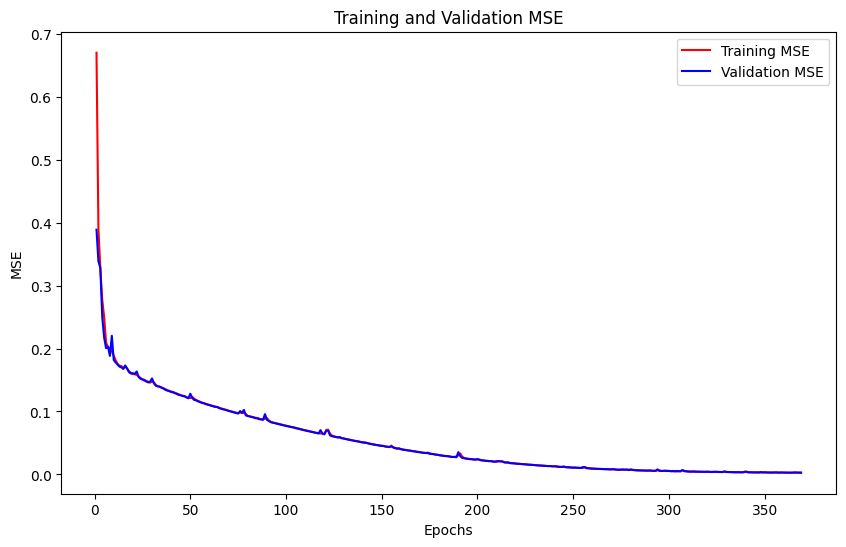

In [23]:
mse = history.history['loss']
val_mse = history.history['val_loss']

epochs = range(1, len(mse) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mse, 'r', label='Training MSE')
plt.plot(epochs, val_mse, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Bilder Diplomarbeit/MSE_NeuroNetz/MSE_NeuroNetz_D4_2')
plt.show()


# GridSearch

In [176]:
def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(264, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(232, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(280, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(264, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(216, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(72, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(216, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(88, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))    

    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
model = KerasRegressor(model=build_model, verbose=2)

# Anpassung der Parameter im param_grid
param_grid = {
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__regularization': [0.001, 0.0001, 0.00001],
    'fit__batch_size': [10, 25, 50, 75],
    'fit__epochs': [50],
    'model__dropout_rate' : [0.0, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# Beste Parameter und Score ausgeben
print("Beste Parameter:", grid_search.best_params_)
print("Beste Genauigkeit:", grid_search.best_score_)

with open("Gridsearch_D4_1.txt", "w") as f:
    f.write(f"Beste Parameter: {grid_search.best_params_}\n")
    f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


In [177]:
# Funktion zum Erstellen des Modells
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Durchführung der Random Search dreimal
for run in range(1, 4):
    # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
    directory = 'random_search'
    project_name = f'random_search_D4_{run}'

    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=100,
        executions_per_trial=1,
        directory=directory,
        project_name=project_name
    )

    # Durchführung des Random Search
    tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=20, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    # Abrufen und Speichern des besten Modells
    best_model = tuner.get_best_models(num_models=1)[0]
    model_path = os.path.join(directory, project_name, 'best_model.h5') 
    best_model.save(model_path)


    # Optional: Abrufen und Ausgeben der besten Hyperparameter
    best_hyperparameters = tuner.get_best_hyperparameters()[0]

    # Konvertieren der Hyperparameter in ein DataFrame
    df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
    # Speichern des DataFrame als CSV
    df_hyperparameters.to_csv(f'random_search_D4_{run}.csv', index=False)

    print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")
